# Test likelihood maximization

This notebook tests the maximization function implemented in the `MDCGaussianNoise` class in `likelihood.py`.

In [1]:
from generate_data import generate_frequency_domain_signal, default_cbc_params
from get_data import get_psd_frequency_series
from likelihood import MDCGaussianNoise, get_sensible_bounds
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.size'] = 12  # global font size
import numpy as np

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## 1 - Generate signal

First we generate a signal (in the frequency domain) using the functions defined in `generate_signal.py`.

In [35]:
cbc_params = dict(default_cbc_params) # Read the default params dictionary defined in generate_signal.py in order not to rewrite everything.
cbc_params['mass1'] = 35
cbc_params['mass2'] = 25
cbc_params['f_lower'] = 5
signal = generate_frequency_domain_signal(cbc_params, ifos=['E1', 'E2', 'E3'])

Waveform approximate duration: 39.6s
Segment duration: 64.0s


## 2 - Create MDCGaussianNoise model

We instanciate an MDCGaussianNoise object with the signal we have generated and the PSD used for the ET MDC.

Since there is no noise, we verify that the optimal log likelihood is 0 and the optimal log likelihood ratio corresponds to 1/2 of the network SNR. Here "optimal" means "computed for the true parameters of the injected CBC signal".

In [36]:
psd = get_psd_frequency_series(signal['E1'].get_sample_frequencies(), signal['E1'].get_delta_f())
psds = {'E1': psd, 'E2': psd, 'E3': psd}

# We know the signal parameters so we can define injection_params and compute optimal likelihoods
model = MDCGaussianNoise(signal, psds, injection_params=cbc_params, fmin=5)

optimal_loglr, optimal_loglikelihood = model.compute_optimal_likelihoods()
print('Optimal log likelihood ratio: ' + format(optimal_loglr, '.2f'))
print('Optimal log likelihood: ' + format(optimal_loglikelihood, '.2f'))

snr_network_sq = model.det_optimal_snrsq('E1') + model.det_optimal_snrsq('E2') + model.det_optimal_snrsq('E3')
print('1/2 network SNR: ' + format(0.5 * snr_network_sq, '.2f'))

Optimal log likelihood ratio: 1014.69
Optimal log likelihood: 0.00
1/2 network SNR: 1014.69


## 3 - Maximize the likelihood

The method `maximize()` calls `scipy.optimize.differential_evolution()`. We can specify the maximal number of iterations and the tolerance, which are parameters of `differential_evolution()`. This method automatically defines the bounds on the parameters over which to maximize, with a radius of 10% from the true values (for example if the true chirp mass is 30, it will restrict the chirp mass in the range 27, 33). When doing the full analysis of the MDC, we will use greater bounds since we are not supposed to know the true values of the injected signal.

In [37]:
res = model.maximize(bounds_method='sensible', max_iterations=100, tol=1e-6)
print(model.maximized_params)
print(model.injection_params)

Iteration 100: negative_loglr = -958.1935450306835
Optimized chirp mass: 25.679784388526006
Optimized mass ratio: 1.3952988629188228
Maximum log-likelihood ratio: 1012.8723943317041
{'mass1': 34.940588123407956, 'mass2': 25.041651686231443, 'spin1z': 0.0, 'spin2z': 0.0, 'ra': 5.59836470277792, 'dec': -1.120037128239277, 'distance': 10147.309335605414, 'inclination': 0.9821102914410741, 'polarization': 5.689862695704308, 'tc': 3.090938078739917, 'coa_phase': 2.5643287143478837, 'spin1x': 0.0, 'spin2x': 0.0, 'spin1y': 0.0, 'spin2y': 0.0, 'eccentricity': 0, 'approximant': 'IMRPhenomD', 'f_lower': 5}
{'mass1': 35, 'mass2': 25, 'spin1x': 0.0, 'spin2x': 0.0, 'spin1y': 0.0, 'spin2y': 0.0, 'spin1z': 0, 'spin2z': 0, 'eccentricity': 0, 'ra': 1.37, 'dec': -1.26, 'distance': 10000, 'polarization': 2.76, 'inclination': 0, 'tc': 3.1, 'coa_phase': 0.3, 'approximant': 'IMRPhenomD', 'f_lower': 5}


## 4 - Reconstruct the signal and compare with the injected signal

The method reconstruct_signal() builds a signal from the maximized parameters. We can then translate it in the time domain and compare with the true injected signal.

In [39]:
signal_reconstructed = model.reconstruct_signal()

Waveform approximate duration: 39.6s
Segment duration: 64.0s


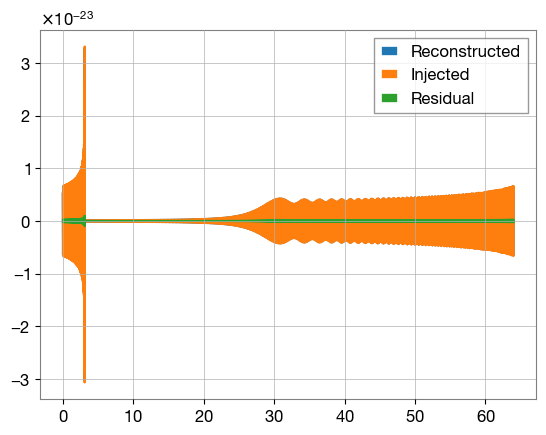

In [40]:
tsd_reconstructed = signal_reconstructed['E1'].to_timeseries()
tsd_injected = model.data['E1'].to_timeseries()

plt.figure()
ax = plt.gca()
ax.plot(tsd_reconstructed.get_sample_times(), tsd_reconstructed, label='Reconstructed')
ax.plot(tsd_injected.get_sample_times(), tsd_injected, label='Injected')
ax.plot(tsd_reconstructed.get_sample_times(), tsd_reconstructed - tsd_injected, label='Residual')

ax.legend()


### Computing time

* The longer the signal is, the longer it takes to generate it and therefore maximize the likelihood. CBC signals become longer when we decrease the minimal frequency and/or the chirp mass.
* For the ET MDC, we would ideally want to go down to a minimal frequency of 5 Hz and chirp mass of 1.21 solar masses. In this case the signal lasts more than 6000s. It is possible that it takes too much computing time. If that's the case, we could decide to increase the minimal frequency to keep the computing cost manageable.